In [1]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

init_notebook_mode(connected=True)

Device: cuda


In [15]:
model = HookedTransformer.from_pretrained('gpt2', device=device)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

Loaded pretrained model gpt2 into HookedTransformer


In [16]:
clean_prompt = '''I'm Davide, I'm 20 years old and I live in Rome.
{
    "name": "Davide",
    "age": "20",
    "city": "Rome"
}

My name is Paul and I live in San Francisco. I've just turned 12.
{'''

corrupted_prompt = '''I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": "20"
}

Hi, I'm Laura and I'm 25.
{
    "name": "'''

#My name is Paul and I've just turned 12.
#{
#    "name": "Paul",
#    "age": 12
#} Hi, I'm Laura and I'm 25.

clean_prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

corrupted_prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

John works at Walmart while Susan studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

### Patching

In [4]:
from transformer_lens.utils import test_prompt

test_prompt(corrupted_prompt, 'Sarah', model)

Tokenized prompt: ['<|endoftext|>', 'David', ' is', ' a', ' student', ' at', ' Stanford', ' and', ' Mary', ' works', ' at', ' McDonald', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'ent', 'ities', '":', ' [', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 0', ',', ' "', 'name', '":', ' "', 'D', 'av', 'ide', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 1', ',', ' "', 'name', '":', ' "', 'Stan', 'ford', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 2', ',', ' "', 'name', '":', ' "', 'Mary', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 3', ',', ' "', 'name', '":', ' "', 'Mc', 'Donald', '"}', '\n', ' ', ' ', ' ', ' ]', '\n', '}', '\n', '\n', 'John', ' works', ' at', ' Walmart', ' while', ' Susan', ' studies', ' at', ' NYU', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'ent', 'ities', '":', ' [', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 0', ',', ' "', 'name', '":', ' "']
Tokenized answer:

Performance on answer token:
Rank: 6117     Logit:  5.06 Prob:  0.00% Token: | Sarah|

Top 0th token. Logit: 15.83 Prob:  8.49% Token: |John|
Top 1th token. Logit: 15.73 Prob:  7.65% Token: |D|
Top 2th token. Logit: 14.85 Prob:  3.16% Token: |Mary|
Top 3th token. Logit: 14.81 Prob:  3.04% Token: |Stan|
Top 4th token. Logit: 14.63 Prob:  2.55% Token: |Mc|
Top 5th token. Logit: 14.51 Prob:  2.26% Token: |David|
Top 6th token. Logit: 14.32 Prob:  1.87% Token: |M|
Top 7th token. Logit: 14.23 Prob:  1.72% Token: |S|
Top 8th token. Logit: 14.15 Prob:  1.57% Token: |K|
Top 9th token. Logit: 14.09 Prob:  1.48% Token: |C|


Ranks of the answer tokens: [(' Sarah', 6117)]

In [5]:
import os
import sys

current_dir = os.getcwd()
atp_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(atp_dir)

from atp import Patching

patching = Patching(model, 'atp')

In [6]:
a_clean = 'Susan'
a_corr = 'John'

a_clean_token = model.to_single_token(a_clean)

patching.patching(clean_prompt, a_clean, corrupted_prompt, a_corr, component='attn_all')

Clean logit difference: -2.828
Corrupted logit difference: -2.330
Patching...


In [126]:
fig = patching.plot()
fig.write_html("fig.html")

In [127]:
def head_modifier_hook(x, hook, head_id, lam=1.2):
    x[:, -1, head_id, :] = lam * x[:, -1, head_id, :]
    return x

In [128]:
test_prompt(clean_prompt, 'Sarah', model)

Tokenized prompt: ['<|endoftext|>', 'David', ' is', ' a', ' student', ' at', ' Stanford', ' and', ' Mary', ' works', ' at', ' McDonald', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'ent', 'ities', '":', ' [', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 0', ',', ' "', 'name', '":', ' "', 'D', 'av', 'ide', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 1', ',', ' "', 'name', '":', ' "', 'Stan', 'ford', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 2', ',', ' "', 'name', '":', ' "', 'Mary', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 3', ',', ' "', 'name', '":', ' "', 'Mc', 'Donald', '"}', '\n', ' ', ' ', ' ', ' ]', '\n', '}', '\n', '\n', 'Susan', ' works', ' at', ' Walmart', ' while', ' John', ' studies', ' at', ' NYU', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'ent', 'ities', '":', ' [', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 0', ',', ' "', 'name', '":', ' "']
Tokenized answer:

Performance on answer token:
Rank: 6663     Logit:  4.87 Prob:  0.00% Token: | Sarah|

Top 0th token. Logit: 16.56 Prob: 14.63% Token: |John|
Top 1th token. Logit: 15.80 Prob:  6.81% Token: |D|
Top 2th token. Logit: 14.75 Prob:  2.38% Token: |Mary|
Top 3th token. Logit: 14.68 Prob:  2.24% Token: |David|
Top 4th token. Logit: 14.61 Prob:  2.07% Token: |Stan|
Top 5th token. Logit: 14.57 Prob:  2.01% Token: |Mc|
Top 6th token. Logit: 14.32 Prob:  1.56% Token: |K|
Top 7th token. Logit: 14.31 Prob:  1.55% Token: |M|
Top 8th token. Logit: 14.30 Prob:  1.53% Token: |S|
Top 9th token. Logit: 14.25 Prob:  1.46% Token: |C|


Ranks of the answer tokens: [(' Sarah', 6663)]

False

In [134]:
# [(8, 11, -1), (9, 6, 1), (9, 9, 1), (10, 0, 1), (10, 1, 1), (10, 7, -1), (10, 10, 1), (11, 10, -1)]
heads = [(8, 11), (9, 6), (10, 0), (10, 1), (11, 10)]
# 9,9
topk_token_probas = []  # List to store topk token probabilities
lams = np.linspace(1, 5, 50)

for lam in tqdm(lams):
    with torch.no_grad():
        proba = model.run_with_hooks(
            model.to_tokens(clean_prompt),
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).softmax(-1)
        
        if lam == 1:
            vals, idxs = proba.topk(8, dim=-1)
            initial_tokens = idxs[0, -1].cpu().tolist()
            if a_clean_token not in initial_tokens:
                initial_tokens.append(a_clean_token)
        else:
            vals = proba[..., initial_tokens]
        
        topk_token_probas.append(vals[0, -1, :].cpu().numpy().tolist())


100%|██████████| 50/50 [00:01<00:00, 39.04it/s]


['John', 'D', 'Mary', 'David', 'Stan', 'Mc', 'K', 'M', 'Susan']

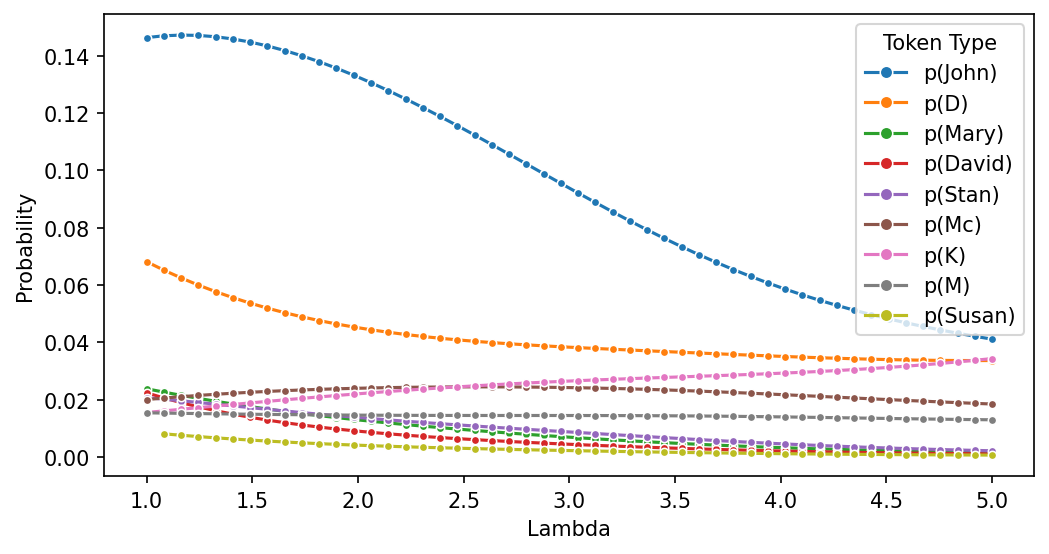

In [139]:
import pandas as pd

fig = plt.figure(figsize=(8, 4), dpi=150)

data = pd.DataFrame(topk_token_probas, columns=[f"p({tok})" for tok in model.to_str_tokens(torch.tensor(initial_tokens))])
data['Lambda'] = lams
data = data.melt(id_vars='Lambda', var_name='Token Type', value_name='Probability')

ax = sns.lineplot(data=data, x='Lambda', y='Probability', hue='Token Type', marker='o')
tmp =[line.set_markersize(4) for line in ax.lines]

In [112]:
heads = [(8, 11), (9, 6), (10, 0), (10, 1), (11, 10)]
lam = 3

tokens = model.to_tokens(clean_prompt)
max_new_tokens = 64

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).argmax(-1)[:, -1, None]

    tokens = torch.cat([tokens, new_tok], dim=-1)

print(model.to_string(tokens)[0])

100%|██████████| 64/64 [00:01<00:00, 39.33it/s]

<|endoftext|>Davide is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "John"},
        {"id": 1, "name": "Walmart"},
        {"id": 2, "name": "McDonald"},
        {"id": 3, "name": "McDonald"},

{

"id": 1, "name": "Walmart"},

"ent


### AtP

In [355]:
patching = Patching(model, 'atp')

In [6]:
x_clean = clean_prompt
x_corr = corrupted_prompt

a_clean = 'Sarah'
a_corr = 'Laura'

patching.patching(x_clean, a_clean, x_corr, a_corr, component='attn_all')

Clean logit difference: 11.632
Corrupted logit difference: -10.022
Patching...


In [7]:
fig = patching.plot()
fig.write_html("fig.html")

Promoting heads: L8H11, L9H6, L9H9, L10H0, L10H1, L10H10

Suppression heads: L10H7, L10H11

In [21]:
prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "Susan"},
        {"id": 1, "name": "Walmart"},
        {"id": 2, "name": "John"},'''

In [22]:
def logits_diff(logits, ans, topk=5):
    top_tokens = logits[0, -1].topk(topk).indices.tolist()
    if isinstance(ans, str):
        ans = model.to_single_token(ans)

    if ans in top_tokens:
        top_tokens.remove(ans)
        
    return logits[0, -1, ans] - logits[0, -1, top_tokens].mean(-1)
    
def get_cache_fwd_and_bwd(tokens, ans):
        filter_not_qkv_input = lambda name: "_input" not in name
        model.reset_hooks()
        cache = {}

        def forward_cache_hook(act, hook):
            cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

        grad_cache = {}

        def backward_cache_hook(act, hook):
            grad_cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

        value = logits_diff(model(tokens), ans, topk=10)
        value.backward()
        model.reset_hooks()
        return (
            value.item(),
            ActivationCache(cache, model),
            ActivationCache(grad_cache, model),
        )

In [23]:
tokens = model.to_tokens(prompt)
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'David'),
 (2, ' is'),
 (3, ' a'),
 (4, ' student'),
 (5, ' at'),
 (6, ' Stanford'),
 (7, ' and'),
 (8, ' Mary'),
 (9, ' works'),
 (10, ' at'),
 (11, ' McDonald'),
 (12, '.'),
 (13, '\n'),
 (14, '{'),
 (15, '\n'),
 (16, ' '),
 (17, ' '),
 (18, ' '),
 (19, ' "'),
 (20, 'ent'),
 (21, 'ities'),
 (22, '":'),
 (23, ' ['),
 (24, '\n'),
 (25, ' '),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' '),
 (30, ' '),
 (31, ' '),
 (32, ' {"'),
 (33, 'id'),
 (34, '":'),
 (35, ' 0'),
 (36, ','),
 (37, ' "'),
 (38, 'name'),
 (39, '":'),
 (40, ' "'),
 (41, 'D'),
 (42, 'av'),
 (43, 'ide'),
 (44, '"},'),
 (45, '\n'),
 (46, ' '),
 (47, ' '),
 (48, ' '),
 (49, ' '),
 (50, ' '),
 (51, ' '),
 (52, ' '),
 (53, ' {"'),
 (54, 'id'),
 (55, '":'),
 (56, ' 1'),
 (57, ','),
 (58, ' "'),
 (59, 'name'),
 (60, '":'),
 (61, ' "'),
 (62, 'Stan'),
 (63, 'ford'),
 (64, '"},'),
 (65, '\n'),
 (66, ' '),
 (67, ' '),
 (68, ' '),
 (69, ' '),
 (70, ' '),
 (71, ' '),
 (72, ' '),
 (73, ' {"'),
 (74, 'id'),


In [24]:
import einops
from tqdm import tqdm

first_output_token_id = 124

patch = torch.zeros(144, len(tokens[0]) - first_output_token_id)

for i in tqdm(range(first_output_token_id, len(tokens[0]))):
    _, cache, grad_cache = get_cache_fwd_and_bwd(tokens[:, :i], tokens[0, i])

    act = cache.stack_head_results(-1)
    grad_act = grad_cache.stack_head_results(-1)

    patch[:, i-first_output_token_id] = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos",
                "sum",
            )[:, -1]

100%|██████████| 68/68 [00:07<00:00,  8.57it/s]


In [25]:
#patch[patch.abs() < 0.2] = 0

In [26]:
import plotly.express as px
ys = [f'L{i}H{j}' for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
xs = [f"{tok} | {i}" for i, tok in enumerate(model.to_str_tokens(prompt)[first_output_token_id:])]

fig = px.imshow(
    patch.cpu().numpy(), 
    x=xs,
    y=ys,
    title=f"Patching results for AtP method",
    color_continuous_scale='RdBu', zmin=-1, zmax=1, aspect='auto'
)
fig.write_html("fig.html")

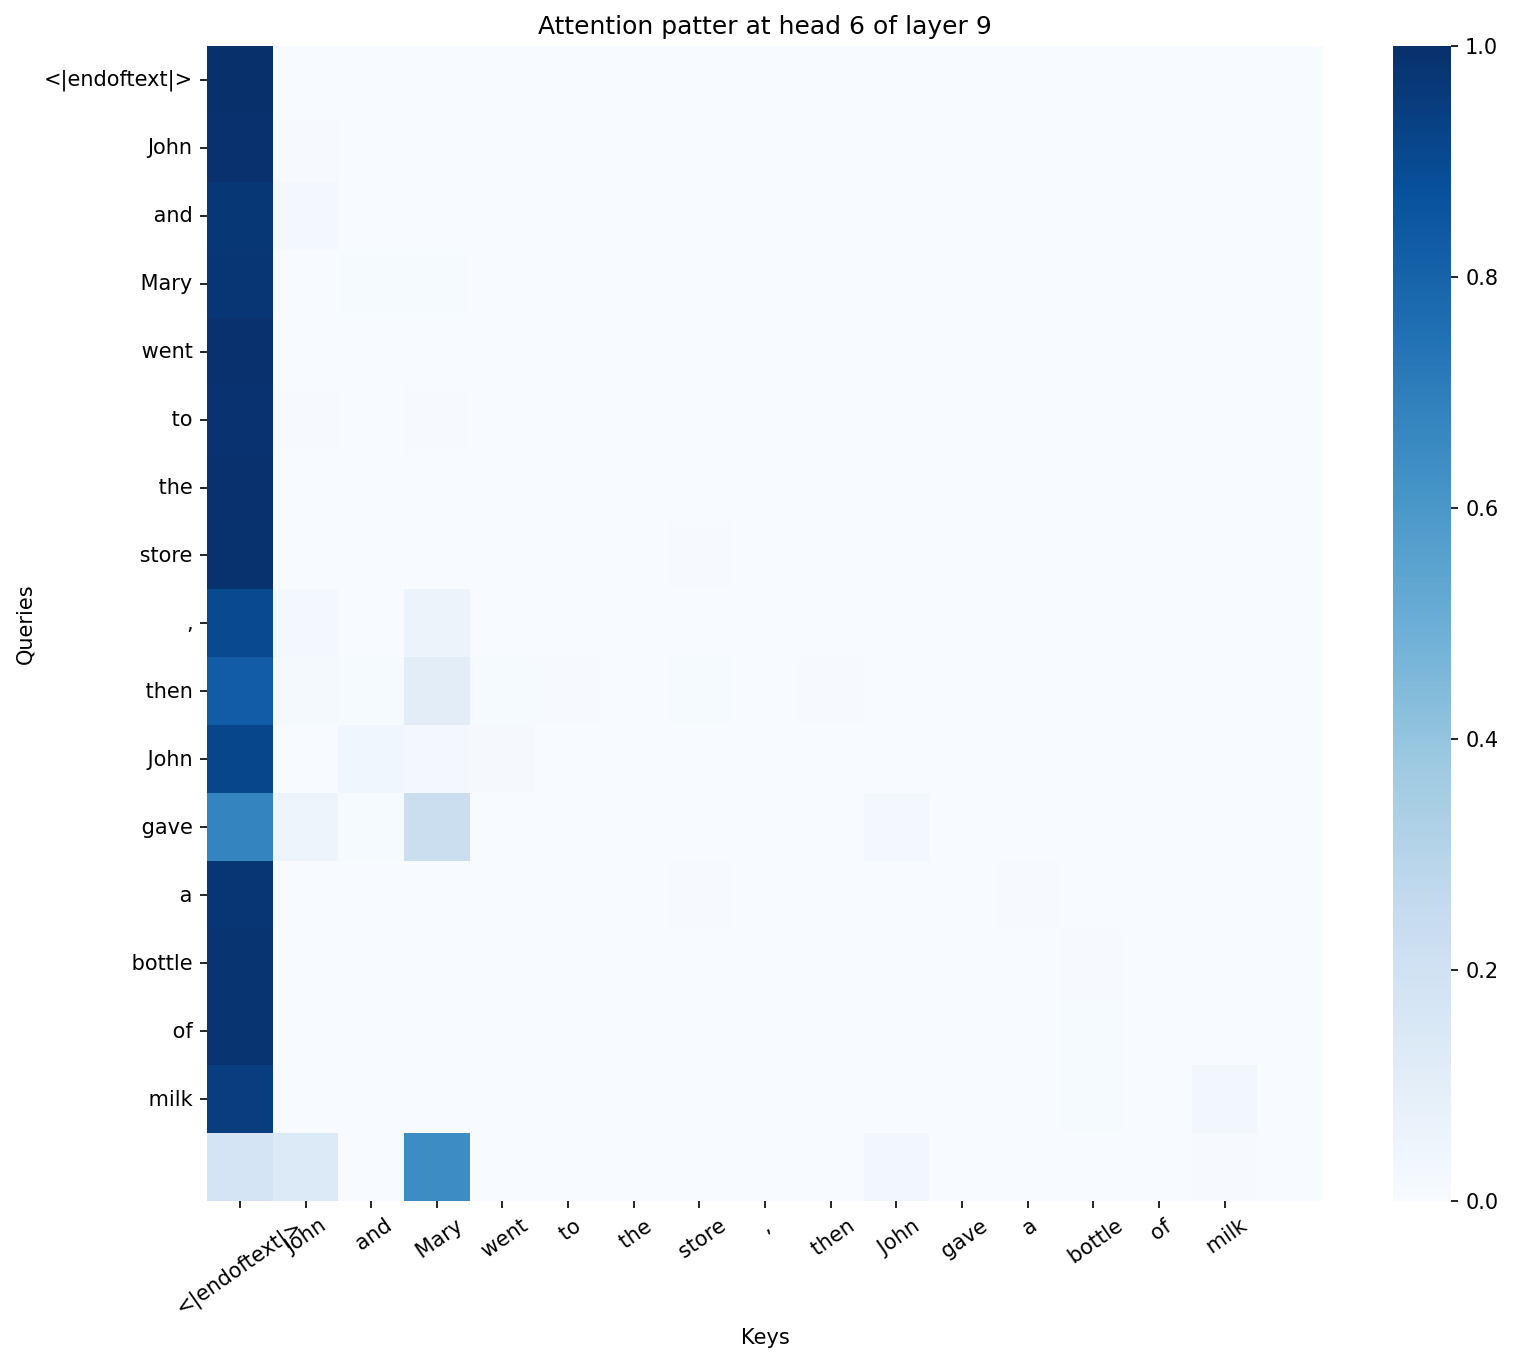

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
layer_id = 9
head_id = 6

data = cache[f'blocks.{layer_id}.attn.hook_pattern'][0, head_id].cpu()
labels = model.to_str_tokens(prompt)[:-1]
# Set up the matplotlib figure
plt.figure(figsize=(12, 10), dpi=150)

# Draw the heatmap
ax = sns.heatmap(data, cmap='Blues', vmin=0, vmax=1)

# Set tick labels
ax.set_xticks([i + 0.5 for i in range(len(labels))])  # Set x-ticks every 10 columns
ax.set_yticks([i + 0.5 for i in range(len(labels))])  # Set y-ticks every 10 rows

# Set tick labels with optional custom labeling
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate tick labels for better visibility
plt.xticks(rotation=35)
plt.yticks(rotation=0)

# Title and labels (optional)
plt.title(f'Attention patter at head {head_id} of layer {layer_id}')
plt.xlabel('Keys')
plt.ylabel('Queries')

# Show the plot
plt.show()

## SAEs

In [4]:
from huggingface_hub import snapshot_download

REPO_ID = "jbloom/GPT2-Small-SAEs-Reformatted"
path = snapshot_download(repo_id=REPO_ID)

Fetching 41 files:   0%|          | 0/41 [00:00<?, ?it/s]

In [5]:
from sae_lens import LMSparseAutoencoderSessionloader
from tqdm import tqdm
import os

saes = []

for l in tqdm(range(model.cfg.n_layers)):
    _, sae_group, activation_store = LMSparseAutoencoderSessionloader.load_pretrained_sae(
        path = os.path.join(path, f"blocks.{l}.hook_resid_pre"), device=device
    )
    sae_group.eval()
    saes.append(sae_group[f'blocks.{l}.hook_resid_pre'])

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning:

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.

  8%|▊         | 1/12 [00:08<01:31,  8.33s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 17%|█▋        | 2/12 [00:15<01:16,  7.63s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 25%|██▌       | 3/12 [00:27<01:25,  9.47s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 33%|███▎      | 4/12 [00:44<01:41, 12.69s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 42%|████▏     | 5/12 [00:52<01:17, 11.03s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 50%|█████     | 6/12 [00:59<00:56,  9.48s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 58%|█████▊    | 7/12 [01:11<00:51, 10.37s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 67%|██████▋   | 8/12 [01:17<00:36,  9.03s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 75%|███████▌  | 9/12 [01:25<00:25,  8.64s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 83%|████████▎ | 10/12 [01:34<00:17,  8.65s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 92%|█████████▏| 11/12 [03:48<00:47, 47.05s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


100%|██████████| 12/12 [03:55<00:00, 19.58s/it]


In [30]:
prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

tokens = model.to_tokens(prompt)

In [31]:
from fancy_einsum import einsum
sae_cache = {}
sae_grad_cache = {}

def feature_edit_hook(x, hook, sae, f_id, pos, lam=2):
    sae_out, f_act, *_ = sae(x)
    f_act[:, pos, f_id] = f_act[:, pos, f_id] * lam
    edit = einsum(
        'b p dsae, dsae dm -> b p dm',
        f_act, sae.W_dec
    ) + sae.b_dec

def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    
    # Function to capture the gradient
    def capture_grad(grad):
        sae_grad_cache[hook.name] = grad.clone()

    # Register the hook to capture the gradient
    if f_act.requires_grad:
        f_act.register_hook(capture_grad)
    
    sae_cache[hook.name] = f_act.detach()
    return sae_out

In [32]:
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'David'),
 (2, ' is'),
 (3, ' a'),
 (4, ' student'),
 (5, ' at'),
 (6, ' Stanford'),
 (7, ' and'),
 (8, ' Mary'),
 (9, ' works'),
 (10, ' at'),
 (11, ' McDonald'),
 (12, '.'),
 (13, '\n'),
 (14, '{'),
 (15, '\n'),
 (16, ' '),
 (17, ' '),
 (18, ' '),
 (19, ' "'),
 (20, 'ent'),
 (21, 'ities'),
 (22, '":'),
 (23, ' ['),
 (24, '\n'),
 (25, ' '),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' '),
 (30, ' '),
 (31, ' '),
 (32, ' {"'),
 (33, 'id'),
 (34, '":'),
 (35, ' 0'),
 (36, ','),
 (37, ' "'),
 (38, 'name'),
 (39, '":'),
 (40, ' "'),
 (41, 'D'),
 (42, 'av'),
 (43, 'ide'),
 (44, '"},'),
 (45, '\n'),
 (46, ' '),
 (47, ' '),
 (48, ' '),
 (49, ' '),
 (50, ' '),
 (51, ' '),
 (52, ' '),
 (53, ' {"'),
 (54, 'id'),
 (55, '":'),
 (56, ' 1'),
 (57, ','),
 (58, ' "'),
 (59, 'name'),
 (60, '":'),
 (61, ' "'),
 (62, 'Stan'),
 (63, 'ford'),
 (64, '"},'),
 (65, '\n'),
 (66, ' '),
 (67, ' '),
 (68, ' '),
 (69, ' '),
 (70, ' '),
 (71, ' '),
 (72, ' '),
 (73, ' {"'),
 (74, 'id'),


In [38]:
# Feature Editing
layer_id = 10
f_id = 2165
pos = 113

hook_point = f'blocks.{layer_id}.hook_resid_pre'

with model.hooks(
    fwd_hooks=[
        (
            hook_point,
            partial(feature_edit_hook, sae=saes[layer_id], f_id=f_id, pos=pos, lam=10),
        )
    ]
): utils.test_prompt(prompt, "Susan", model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'David', ' is', ' a', ' student', ' at', ' Stanford', ' and', ' Mary', ' works', ' at', ' McDonald', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'ent', 'ities', '":', ' [', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 0', ',', ' "', 'name', '":', ' "', 'D', 'av', 'ide', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 1', ',', ' "', 'name', '":', ' "', 'Stan', 'ford', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 2', ',', ' "', 'name', '":', ' "', 'Mary', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 3', ',', ' "', 'name', '":', ' "', 'Mc', 'Donald', '"}', '\n', ' ', ' ', ' ', ' ]', '\n', '}', '\n', '\n', 'Susan', ' works', ' at', ' Walmart', ' while', ' John', ' studies', ' at', ' NYU', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'ent', 'ities', '":', ' [', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 0', ',', ' "', 'name', '":', ' "']
Tokenized answer:

Performance on answer token:
Rank: 4019     Logit:  6.44 Prob:  0.00% Token: | Susan|

Top 0th token. Logit: 16.56 Prob: 14.63% Token: |John|
Top 1th token. Logit: 15.80 Prob:  6.81% Token: |D|
Top 2th token. Logit: 14.75 Prob:  2.38% Token: |Mary|
Top 3th token. Logit: 14.68 Prob:  2.24% Token: |David|
Top 4th token. Logit: 14.61 Prob:  2.07% Token: |Stan|
Top 5th token. Logit: 14.57 Prob:  2.01% Token: |Mc|
Top 6th token. Logit: 14.32 Prob:  1.56% Token: |K|
Top 7th token. Logit: 14.31 Prob:  1.55% Token: |M|
Top 8th token. Logit: 14.30 Prob:  1.53% Token: |S|
Top 9th token. Logit: 14.25 Prob:  1.46% Token: |C|


Ranks of the answer tokens: [(' Susan', 4019)]

In [42]:
from functools import partial

component = 'resid_pre'

out = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    utils.get_act_name(component, layer_id),
                    partial(reconstr_hook, sae=saes[layer_id]),
                )
            for layer_id in range(model.cfg.n_layers)]
        ).log_softmax(-1)

ans = model.to_single_token('John')
loss = - out[0, -1, ans]

loss.backward()

In [43]:
act = torch.stack(list(sae_cache.values()))
grad_act = torch.stack(list(sae_grad_cache.values()))

patch = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos d_model",
                "sum",
            )

In [45]:
#patch_1 = patch
#patch_2 = patch
patch = patch_1 - patch_2

In [48]:
vals, idxs = patch.mean(1).topk(5, dim=-1)

In [55]:
act.shape

torch.Size([12, 1, 151, 24576])

In [57]:
(sae_grad_cache['blocks.8.hook_resid_pre'] * sae_cache['blocks.8.hook_resid_pre'])[0, :, idxs[8]]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00],
        [ 5.1259e-05,  1.2423e-04, -1.9653e-05,  1.0359e-04, -1.2293e-05],
        [-1.1158e-05,  6.4764e-05, -4.4216e-05,  5.2106e-05, -1.5575e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0035e-05,  8.6076e-05, -3.7135e-05,  7.4282e-05, -1.4578e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.7539e-05,  5.6588e-05, -4.6138e-05,  4.6425e-05, -1.6470e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.

In [54]:
sae_cache['blocks.8.hook_resid_pre'][0, :, idxs[8]]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.4030e+01, 6.5246e+01, 7.1185e+01, 5.7004e+01, 3.4350e+01],
        [1.2998e+05, 1.3971e+05, 1.6332e+05, 1.4452e+05, 9.2726e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.6407e+02, 2.0525e+02, 2.3432e+02, 2.0761e+02, 1.3887e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.3511e+02, 9.8661e+02, 1.1753e+03, 1.0489e+03, 6.5055e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00,

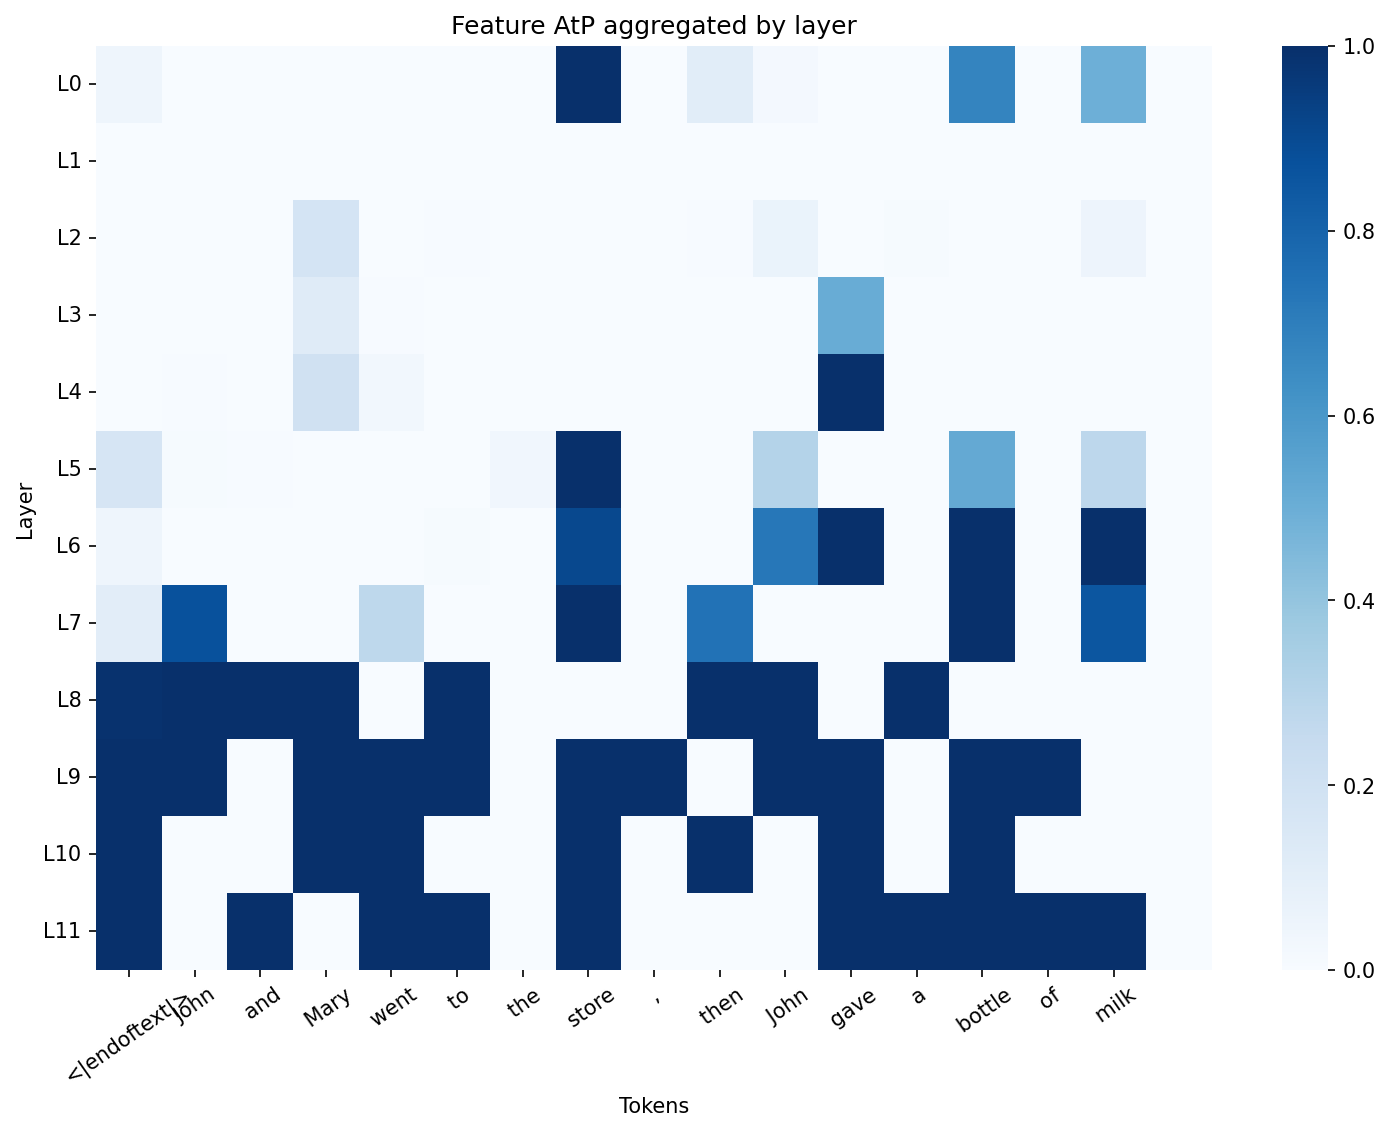

In [153]:
plt.figure(figsize=(12, 8), dpi=150)

ys = [f"L{i}" for i in range(model.cfg.n_layers)]

# Draw the heatmap
ax = sns.heatmap(patch.cpu().sum(-1), cmap='Blues', vmin=0, vmax=1)

# Set tick labels
ax.set_xticks([i + 0.5 for i in range(len(labels))])  # Set x-ticks every 10 columns
ax.set_yticks([i + 0.5 for i in range(len(ys))])  # Set y-ticks every 10 rows

# Set tick labels with optional custom labeling
ax.set_xticklabels(labels)
ax.set_yticklabels(ys)

# Rotate tick labels for better visibility
plt.xticks(rotation=35)
plt.yticks(rotation=0)

# Title and labels (optional)
plt.title('Feature AtP aggregated by layer')
plt.xlabel('Tokens')
plt.ylabel('Layer')

# Show the plot
plt.show()

In [170]:
def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    sae_cache[hook.name] = f_act  # Store for reference; not detach here as we need gradients
    return sae_out

def interpolate(input, baseline, steps=50):
    return [baseline + (float(i) / steps) * (input - baseline) for i in range(steps + 1)]


In [171]:
# IG
from functools import partial

# Generate baseline
baseline_tokens = torch.zeros_like(tokens)

# Interpolate between baseline and actual tokens
interpolated_inputs = interpolate(tokens, baseline_tokens, steps=50)

# Container for accumulated gradients
accumulated_grads = []

for interp_tokens in interpolated_inputs:
    # Run model forward with hooks
    out = model.run_with_hooks(
                interp_tokens,
                fwd_hooks=[
                    (
                        utils.get_act_name(component, layer_id),
                        partial(reconstr_hook, sae=saes[layer_id]),
                    ) for layer_id in range(model.cfg.n_layers)
                ]
            ).log_softmax(-1)
    
    # Target token
    ans = model.to_single_token('Mary')
    loss = -out[0, -1, ans]  # Assuming scalar output for simplification

    # Backward to get gradients on interpolated inputs
    loss.backward()

    # Collect gradients from SAE features
    for name in sae_cache:
        if sae_cache[name].grad is not None:
            if name not in accumulated_grads:
                accumulated_grads[name] = []
            accumulated_grads[name].append(sae_cache[name].grad.clone())

    # Zero all gradients for the next iteration
    model.zero_grad()

# Average the gradients across all steps
integrated_gradients = {name: torch.stack(grads).mean(0) * (tokens - baseline_tokens) for name, grads in accumulated_grads.items()}


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [23]:
json_text = """{
    "question": "What's the capital of France?",
    "answer": Paris
    }"""

non_json_text = [
    """What's the capital of France?
Paris""",
    """These are the things I love:
1. Food,
2. Sea,
3. Friends""",
    """An old man once told me: "You will succeed in life".
I hope him to be true."""
]

In [7]:
features_dict = {l: [] for l in range(model.cfg.n_layers)}

with open("json_features.txt", "r") as f:
    features = f.readlines()

for f in features:
    f = f.strip().split('-')
    layer = int(f[0])
    features_dict[layer].append(f[1])

In [26]:
features_act_dict = {
    'L': [],
    'N': [],
    'JSON Activation': [],
    'Non-JSON Activation': []
}

with torch.no_grad():
    _, json_cache = model.run_with_cache(model.to_tokens(json_text))
    _, non_json_cache = model.run_with_cache(model.to_tokens(non_json_text[2]))

for l in range(model.cfg.n_layers):
    json_activations = json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]
    non_json_activations = non_json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]

    with torch.no_grad():
        _, json_features_act, *_ = saes[l](json_activations)
        _, non_json_features_act, *_ = saes[l](non_json_activations)

    for f in features_dict[l]:
        f = int(f)
        features_act_dict['L'].append(l)
        features_act_dict['N'].append(f)
        val, ix = json_features_act[0, :, f].max(0)
        features_act_dict['JSON Activation'].append([val.item(), ix.item()])
        val, ix = non_json_features_act[0, :, f].max(0)
        features_act_dict['Non-JSON Activation'].append([val.item(), ix.item()])        

In [27]:
import pandas as pd

pd.DataFrame(features_act_dict)

,L,N,JSON Activation,Non-JSON Activation
0,0,23622,"[0.0, 0]","[0.0, 0]"
1,1,5310,"[20.185184478759766, 8]","[0.0, 0]"
2,2,10521,"[25.650108337402344, 8]","[0.0, 0]"
3,4,21672,"[3.7655177116394043, 9]","[0.0, 0]"
4,4,8148,"[1.687551736831665, 18]","[0.0, 0]"
5,6,5682,"[24.25801658630371, 23]","[0.0, 0]"
6,6,3596,"[21.313154220581055, 2]","[0.0, 0]"
7,6,13428,"[0.9894517660140991, 8]","[0.0, 0]"
8,6,2164,"[0.0, 0]","[0.0, 0]"
9,7,20690,"[25.253623962402344, 23]","[0.0, 0]"


In [21]:
list(enumerate(model.to_str_tokens(json_text)))

[(0, '<|endoftext|>'),
 (1, '{'),
 (2, '\n'),
 (3, ' '),
 (4, ' '),
 (5, ' '),
 (6, ' "'),
 (7, 'question'),
 (8, '":'),
 (9, ' "'),
 (10, 'What'),
 (11, "'s"),
 (12, ' the'),
 (13, ' capital'),
 (14, ' of'),
 (15, ' France'),
 (16, '?",'),
 (17, '\n'),
 (18, ' '),
 (19, ' '),
 (20, ' '),
 (21, ' "'),
 (22, 'answer'),
 (23, '":'),
 (24, ' Paris'),
 (25, '\n'),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' }')]